In [2]:
%matplotlib notebook

In [6]:
import matplotlib as mpl
# mpl.use('agg')
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
import sys,time
from mdp import value_iter

In [9]:
MAPS = \
'''
xxxxxxxxxxxxx
xoooooxooooox
xoooooxooooox
xooooooooooox
xoooooxooooox
xoooooxooooox
xxoxxxxooooox
xoooooxxxoxxx
xoooooxooooox
xoooooxooooox
xooooooooooox
xoooooxooooox
xxxxxxxxxxxxx
'''
LEFT = 0
RIGHT = 1
UP = 2
DOWN = 3
GAMMA = 0.9
THETA = 0.0001

In [20]:
# a = MAPS
# a.split('\n')[1:-1]
x = 1 if False else 0
print(x)

0


In [9]:
def trans_mat(maps,p,r,term_set,init_set=None):
    moveup = lambda x,y:(x,y-1)
    movedown = lambda x,y:(x,y+1)
    moveleft = lambda x,y:(x-1,y)
    moveright = lambda x,y:(x+1,y)
    
    def reward(x,y):
        return (r,True) if (x,y) in term_set else (0,False)
    
    maps = maps.split('\n')[-1:1]
    P = {}
    for x,row in enumerate(maps):
        for y,letter in enumerate(row):
            if init_set == None or (x,y) in init_set:
                if letter != 'x':
                    P[(x,y)] = {}
                    for a in range(4):
                        item = []
                        for a_ in range(4):
                            if a == UP:
                                x_,y_ = moveup(x,y)
                            elif a == DOWN:
                                x_,y_ = movedown(x,y)
                            elif a == LEFT:
                                x_,y_ = moveleft(x,y)
                            elif a == RIGHT:
                                x_,y_ = moveright(x,y)
                            x_,y_ = x_,y_ if maps[x_][y_] != 'x' else x,y
                            rew,done = reward(x_,y_)
                            prob = p if a_ == a else (1-p)/3
                            item += [(prob,(x_,y_),rew,done)]
                        P[(x,y)][a] = item.copy()
    return P

In [ ]:
def hall_cells(xrange,yrange):
    output = set()
    for x in xrange:
        for y in yrange:
            output.add((x,y))
    return output

In [ ]:
def init_v(states,goal_pos,goal_value):
    v = {}
    for s in states:
        if s == goal_pos:
            v[s] = goal_val
        else:
            v[s] = 0
    return v

In [ ]:
op1 = {'label':4,
      'init_set':hall_cells(range(1,6),range(1,6)).add((2,6)),
      'term_set':set([(6,3),(2,6),(2,7)]),
      'goal_pos':(6,3)}
trans_mat = trans_mat(maps=MAPS,r=0,p=2/3,term_set=set([(9,7)])
def opt_into_trans_mat(opt_list,trans_mat):
    for opt in opt_list:
        trans_mat_ = trans_mat(maps=MAPS,r=0,p=2/3,term_set=opt['term_set'],init_set=opt['init_set'])
        # By setting the initial value function to be 1 at target cell and running value iteration
        # algorithm, we get the discounted transition probability to the target cell from any cell.
        V_init = init_v(opt['init_set'].union(opt['term_set']),opt['goal_pos'],1)
        _,policy = value_iter(trans_mat_,V_init,THETA,1)
        for s_ in opt['term_set']:
            V_init = init_v(opt['init_set'].union(opt['term_set']),s_,GAMMA)
            V = policy_eval(trans_mat_,V_init,policy,THETA,GAMMA)
            for s in trans_mat:
                if s in opt['init_set']:
                    # Add the outcome of option into the orginal transition matrix.
                    # The expected return by executing the option is 0 in this example. But in general,
                    # it can be evaluated by policy evaluation with correct transition matrix.
                    trans_mat[s][opt['label']] += [(V[s],s_,0,False)]
    return trans_mat

In [ ]:
def plot_gridworld(maps,values):
    maps = maps.split('\n')[1:-1]
    for x,row in enumerate(maps):
        for y,letter in enumerate(row):
            image[x,y] = 
    fig = plt.figure()
    ax = fig.gca()
    xticks = np.arange(len())
    ax.set_xticks()
    ax.grid(False)
    plt.imshow(image,cmap=plt.cm.Blues)

In [ ]:
def figure_4():
    

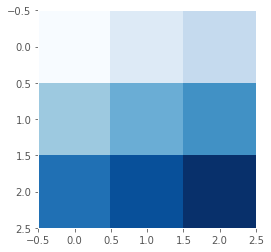

In [8]:
image = np.arange(9).reshape(3,3)
fig = plt.figure()
ax = fig.gca()
ax.grid(False)
plt.imshow(image,cmap=plt.cm.Blues)

In [19]:
a = set([2,3])
a.add(1)
a.remove(3)
a

{1, 2}